# Flow and mechanics in FEniCS


## CSF flow in the brain
The brain and spinal coord are surrounded by cerebrospinal fluid (CSF). Tracer experiments show that tracers injected into the CSF quickly move into the brain itself. This raises an important mechanical question: What are the governing forces that make tracers move through the brain?

| <img src="figures/sleep.jpeg" width=500> |
|:--:|
| Tracers moving through the brain. *Sleep deprivation impairs molecular clearance from the human brain* by V. Vinje et. al. |



## Darcy's law:

Previously you may have studied Darcy's law, which describes fluid flow through a *porous medium*. Porous media are materials that can be split into two parts: a skeleton and a pore space.

| <img src="figures/porous_media.png" width=350> |
|:--:|
| *Water flow through a non-uniform macro-porous medium. Physica solutions* |

Some examples of porous media are
1. A sponge
2. Sandstone (sand particles make up the skeleton)
3. Biological tissue (cells make up the skeleton and extracellular space makes up the pore space)


| <img src="figures/extracellular.png" width=450> |
|:--:|
| 3D constructed brain tissue using data from a 3D electron microscope. The space is divided into sheets (i.e. space between two parallel cell membranes) and tunnels (where three cell membranes meet). Extracellular fluid can move through the sheets and tunnels that make up the so-called pore space. *Interstitial solute transport in 3D reconstructed neuropil occurs by diffusion rather than bulk flow, Holter et. al, PNAS* |

To compute flow in porous media we can use Darcy's law. The Darcy flow model was formulated by Henry Darcy based on his experiments of water flowing through a column of sand. The same equation can be rigourously derived by averaging Navier-Stokes flow in the pore space of a porous media. 

The stationary Darcy flow equations read as follows:
\begin{align*}
u &= -K \nabla p && \text{ in } \Omega \\
\nabla \cdot u &= f &&\text{ in } \Omega
\end{align*}
augmented by some boundary conditions

$$p(x) = p_D(x) \qquad \text{on } \partial \Omega$$

The variable $K$ is the *permeability* of the porous media, and depends on the porosity of the material and the tortuousity of the pore network.


We can collapse these two the simpler primal form:
$$\nabla \cdot \left( -K \; \nabla p(x) \right) = f(x) \qquad \text{on } \Omega$$
In this equation we solve for the unknown pressure $p$ only. Velocity is calculated by postprocessing the result:

$$u = -K \; \nabla p(x) \qquad \text{on } \Omega$$



Finally $u$ is the _Darcy flux_, that is, the observed flow rate through the porous medium. Due to the porosity $\phi$ of the domain, the velocity $\bar{u}$ of a fluid particle _within the fluid domain_, is faster than $u$ according to

$$\bar{u} = u / \phi$$






### FEniCS implementation

In [87]:
%matplotlib inline
from ufl.operators import Max
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

We first set up the problem parameters and variational forms

In [88]:
# Create mesh and define function space
n = 32
mesh = UnitSquareMesh(n, n)
W = FunctionSpace(mesh, 'Lagrange', 1) # pressure space
V = VectorFunctionSpace(mesh, 'DG', 0) 

# Define permeability and porosity
k_min = 0.01
x = SpatialCoordinate(mesh)
K = Max(exp(-0.5*((x[1]-0.5-0.1*sin(10*x[0]))/0.1)**2), k_min)


# Define boundary condition
pD = Expression('(1-x[0])*(t+1)', t=0.0, degree=1)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(W, pD, boundary)

# Define variational problem
p = TrialFunction(W)
q = TestFunction(W)
f = Constant(0.0)
a = K * inner(grad(p), grad(q))*dx
L = f * q * dx

p = Function(W)

solve(a == L, p, bc)

Solving linear variational problem.


### Visualization

We can visualize the solution inline in this notebook or using paraview. The inline visualization is a good option for 2D plots.

Text(0.5, 1.0, 'Permeability')

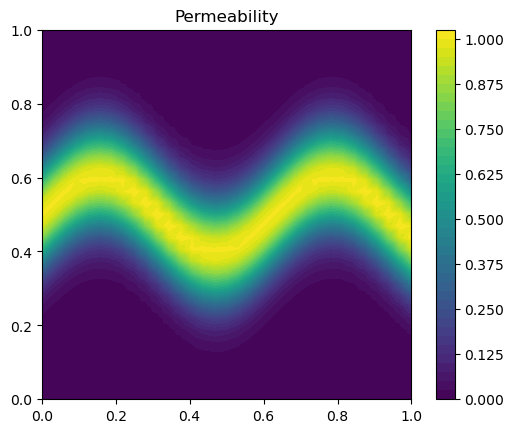

In [89]:
## Inline visualization
K_i = project(K, W)
fig = plot(K_i)
plt.colorbar(fig)
plt.title('Permeability')

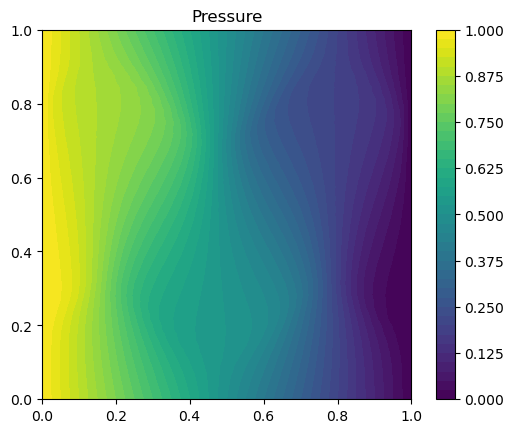

In [90]:
fig = plot(p)
plt.colorbar(fig)
plt.title('Pressure');

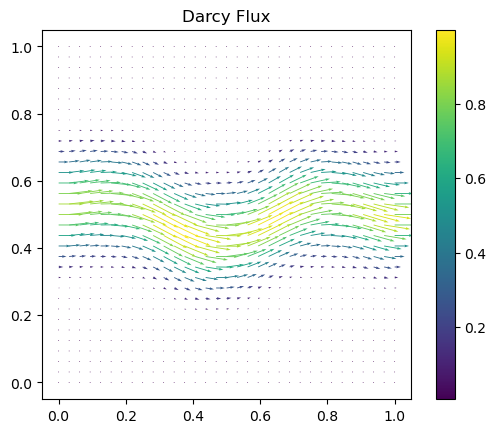

In [91]:
u = project(-K*grad(p), V) 
fig = plot(u)
plt.colorbar(fig)
plt.title('Darcy Flux');

#### Quick exercise
Change the permeability value by a factor of 10... What happens to the pressure? What happens to the Darcy flux?

### Paraview visualization

In most cases, [Paraview](https://www.paraview.org/) is recommended to plot with as it offers a lot more flexibility. We will use the XDMF file format to store results. An example of how an XDMF file can store a function is shown below.

The function `write_checkpoint()` takes 3 arguments, plus one optional argument. The arguments are the FEniCS Function to be stored, a label for the function, and time. The optional argument can be used to set the file write mode to `"append"` (default `append=False`). Files are closed at the very end of the code.

The `.xdmf` file is now stored in the folder named perfusion. If you download this file to your laptop, you can then open it in Paraview.

In [95]:
# Example for saving to .xdmf
p = Function(W)
t = 0.0
file = XDMFFile("perfusion/test.xdmf")
# do some stuff
file.write_checkpoint(p, 'pressure', t, append=False) # For the first instance of write checkpoint, append should be false
# do some more stuff
t += dt
file.write_checkpoint(p, 'pressure', t, append=True) # For all other instances of write_checkpoint, append should be true

file.close()

### Time dependency
Darcy's law itself is a stationary equation (simple relationship between pressure and velocity, no time dependence). However, in mechanics applications, and for biological systems in particular, we are most often interested in solving time-dependent problems. Dynamic flow can be introduced into the problem by applying dynamic boundary conditions $p_D(t)$ or source terms $f(x,t)$. We can thus easily expand our code for solving Darcy's law to include dynamic boundary conditions.


#### Exercise: Complete the code

Complete the code below such that the variational form above is solved until $t = 1.0$ using the given time step size. Store the solutions as a list. Plot the solutions at the end.

In [92]:
# Create mesh and define function space
n = 32
mesh = UnitSquareMesh(n, n)
W = FunctionSpace(mesh, 'Lagrange', 1) # pressure space
V = VectorFunctionSpace(mesh, 'Lagrange', 2)

# Set parameters
dt = 0.25
t = 0.0
x = SpatialCoordinate(mesh)
k_min = 0.01
K = Max(exp(-0.5*((x[1]-0.5-0.1*sin(10*x[0]))/0.1)**2), k_min)

# Define boundary condition
pD = Expression('(1-x[0])*(t+1.0)', t=0.0, degree=1)

def boundary(x, on_boundary):
    return on_boundary

bcs = [DirichletBC(W, pD, boundary)]

p = TrialFunction(W)
q = TestFunction(W)
f = Constant(0.0)
a = K * inner(grad(p), grad(q))*dx
L = f*q*dx

In [93]:
p_sols = [] # append solutions to this list, using p_sols.append(p)
append = False
while t<= 1.0:
    ph = Function(W)
    u = Function(V)
    t += dt
    
    # *** Insert code here ***

#### Plot solution

In [94]:
for ix, p in enumerate(p_sols):
    fig = plt.figure()
    plt.colorbar(plot(p))
    plt.title(f'Pressure, t={ix*dt:1.2f}')
    plt.show()

### Verification and error analysis

The finite element method computes numerical approximations of the exact solution. The finer the mesh we use, the more accurate the approximation, but the more computationally expensive the problem. We are thus interested in knowing which mesh resolution leaves us with sufficient confidence in our computed results, which we achieve by *quantifying the error* of our approximation.

#### Method of manufactured solutions

When we know the exact solution to our problem (like in the Darcy's law example from the previous lecture) we can simply use this exact solution as our reference quantity. Using this method of manufactured solutions we can verify our implementation of our variational form. Assume that the exact solution should be

$$p_e(x) = 1 - x^2$$

In FEniCS we can represent this exact solution as

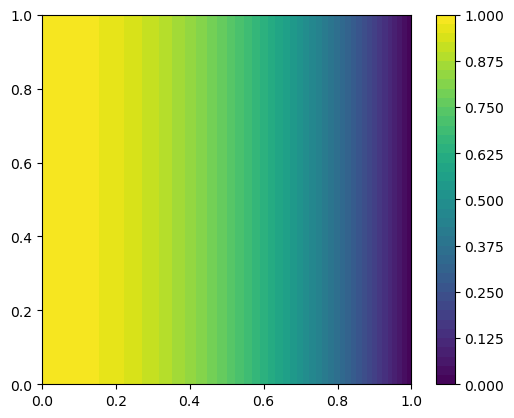

In [113]:
mesh = UnitSquareMesh(16,16)
P = FunctionSpace(mesh, 'Lagrange', 2)
p_e = project(Expression("1-x[0]*x[0]", degree=2), P)
fig = plot(p_e)
plt.colorbar(fig)

Inserting the expression for $p_e$ into Darcy's law while choosing $\boldsymbol{K} = 1$ gives

$$f(\boldsymbol{x}) = 2$$

Thus, to test our implementation of Darcy's law against our manufactured solution $p_e$ we need to solve

$$\nabla \cdot \left( -\boldsymbol{K} \; \nabla p(\boldsymbol{x}) \right) = f(\boldsymbol{x}) \qquad \text{on } \Omega$$

with $\boldsymbol{K} = 1$, $f(\boldsymbol{x}) = 2$, augmented by Dirichlet boundary conditions

$$p(\boldsymbol{x}) = 1 \qquad \text{on } \partial \Omega_{x=0}$$
$$p(\boldsymbol{x}) = 0 \qquad \text{on } \partial \Omega_{x=1}$$

#### FEniCS implementation

Solving linear variational problem.


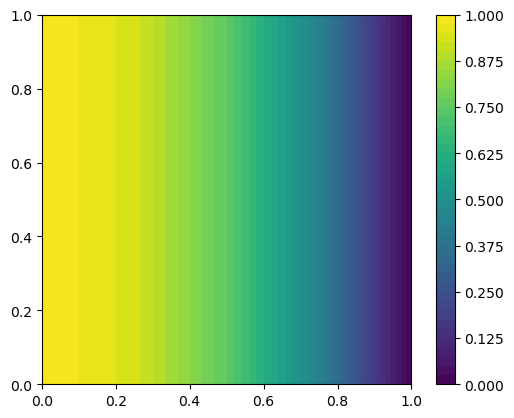

In [114]:
# Create mesh and define function space
n = 4
mesh = UnitSquareMesh(n, n)
P = FunctionSpace(mesh, 'Lagrange', 1) # pressure space

# Define permeability and porosity
K = Constant(1)
f = Constant(2)

# Define boundary condition
def left(x, on_boundary):
    return on_boundary and near(x[0], 0.0)

def right(x, on_boundary):
    return on_boundary and near(x[0], 1.0)

bcl = DirichletBC(P, Constant(1), left)
bcr = DirichletBC(P, Constant(0), right)
bcs = [bcl, bcr]

# Define variational problem
p = TrialFunction(P)
q = TestFunction(P)
a = K * inner(grad(p), grad(q))*dx
L = f * q * dx

# Solve
p = Function(P)
solve(a == L, p, bcs=bcs)

# Plot solution
fig = plot(p)
plt.colorbar(fig)

Remark: In this example, we did not assign Dirichlet boundary conditions on the top and bottom. What happens then? 

Implicitly we have set $\nabla p \cdot n = 0$ there. To see this, recall that we make the variational formulation by integrating by parts against a test function $q \in V$, where $V= \{ q\in H^1(\Omega): Tq = 0 \text{ on } \partial \Omega_{x=0} \cup \partial \Omega_{x=1} \}$. This yields
\begin{align*}
\int_\Omega -\Delta p \, \mathrm{d}x &= \int_\Omega \nabla p \cdot \nabla q \, \mathrm{d}x - \int_{\partial \Omega} \nabla p \cdot n q\, \mathrm{d}s  \\
&= \int_\Omega \nabla p \cdot \nabla q \, \mathrm{d}x - \int_{\partial \Omega_{y=0} \cup \partial \Omega_{y=1}} \nabla p \cdot n q\, \mathrm{d}s.
\end{align*}

### Error analysis

The exact solution above and numerical solution look pretty similar! However, given that we approximated a *quadratic solution* using *linear finite elements*, we expect the error of our numerical solution to be non-zero. If we had used quadratic elements for this calculation, we would always arrive at our exact solution (*You should take the time to test this with your code later*). So how similar is our numerical solution to the exact solution? To quantify the error, we often compute the so-called *$L^2$-norm* of the error

$$E = \sqrt{ \int_{\Omega} (u_e - u)^2~\mathrm{d}x}$$

where $u_e$ is the exact solution and $u$ is our numerical solution. In FEniCS we can compute the $L^2$-norm (and other norms) using

In [115]:
error_L2 = errornorm(p_e, p, 'L2')
print(error_L2)

0.011410886614696436
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


#### Exercise:
Turn your code for Darcy's law into a function that takes the mesh resolution n as an argument. Use this function to compute the error for increasing mesh resolutions, and plot the error over the mesh resolution.

In [100]:
def darcy(n):
    # insert your code here
    pass

meshes = [2**i for i in range(10)]
error = []

# insert your code here
    
# uncomment the two lines below to plot results
# plt.semilogy(meshes, error)
# plt.show()

#### Exercise:
Try approximating with $P^2$ elements - what happens to the error?

### Residuals:
Let's assume that we do not know the exact solution. In this case we can still calculate the error, but using a different reference quantity. Inserting the equation for velocity $u$ into Darcy's law gives

$$\nabla \cdot u = f(x)$$

which we can test for using our computed $u$. When $f(x) = 0$ we call this equation the *divergence-free condition* for Darcy's law.

#### Exercise:
Compute the residual for different mesh refinements.

In [101]:
meshes = [2**i for i in range(10)]
error = []

# insert your code here

## Elastic deformation

Our brains deform and jiggle with the heartbeat.

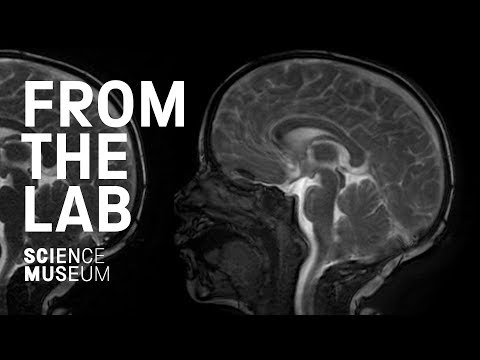

In [116]:
from IPython.display import YouTubeVideo

YouTubeVideo('3Ursf81QoC8', width=500)

What equations describe this type of deformation?

### Linear elasticity

Linear elasticity describes small elastic deformations that follow a linear relationship between stress and strain. 


#### Note:
Biological tissue can often not be modelled well using linear elasticity. 
This will be discussed further in the Cardiac Tissue Mechanics and Fluid Dynamics stream of the Summer School.

Here we stick with the basics and study linear elasticity.

### Hooke's law

Let us denote  
- Stress $\sigma$: External force applied on a specified area
- Strain $\varepsilon$: Amount of deformation  


Hooke observed that, for relatively small deformations of an object, the displacement (i.e size of the deformation) is proportional to the deforming force
 <img src="figures/elasticity.png" width=800>   
Here, $E$ is the elasticity modulus of the material.


### Momentum balance
The momentum balance equation for small elastic deformations of a body $\Omega$ reads

$$-\nabla \cdot \sigma = f \qquad \text{in } \Omega$$

with stress tensor $\sigma$ and body force per unit volume $f(\boldsymbol{x})$. 

This equation is derived by the balancing the surface forces acting on each wall of a cubic element.

## Elasticity equations
Let $\varepsilon$ denote the elasticity tensor. For our constitutive equation we choose
$$\sigma = \lambda \; tr(\varepsilon) I + 2 \mu \varepsilon$$
$$\varepsilon = \frac{1}{2} (\nabla u + (\nabla u)^T)$$

The stress tensor depends on two parameters that are specific for every material, the Lamè constants $\lambda$ and $\mu$. The trace operator $tr(A)$ represents the sum of the elements on the main diagonal of a tensor $A$, $I$ is the identity tensor, and $u(x)$ is the displacement vector field. Inserting the definition of $\varepsilon$ into $\sigma$ gives

$$\sigma = \lambda (\nabla \cdot u) I + \mu (\nabla u + (\nabla u)^T)$$

Note that while we have written the momentum balance equation in terms of the stress tensor $\sigma$, our primary unknown is the displacement vector field $u$.

### Variational form

Deriving the variational form requires multiplication of the governing equation by a test function $v \in \hat{V}$, integrating over the domain $\Omega$.

$$- \int_{\Omega} (\nabla \cdot \sigma) \cdot v dx = \int_{\Omega} f \cdot v dx$$

Note that this time, as our unknown $u$ is vector-valued, our test function $v$ is also vector-valued. Note also from the definition of $\sigma$ that the term $\nabla \cdot \sigma$ contains second-order derivatives of $u$, so we integrate this term by parts

$$- \int_{\Omega} (\nabla \cdot \sigma) \cdot v dx = \int_{\Omega} \sigma : \nabla v dx - \int_{\partial \Omega} (\sigma \cdot n) \cdot v ds$$

where the colon operator denotes the *inner product* between two tensors:

$$A : B = \sum_i \sum_j A_{ij} B_{ij} = A_{11} B_{11} + A_{12} B_{12} + \ldots$$

The term $\sigma \cdot n$ denotes traction or stress at the boundary in the outward normal direction of the boundary and is often prescribed as a boundary condition. 

In fluid-structure interaction problems such as the deformation of an arterial wall due to the oscillating blood pressure, the boundary traction is directly proportional to the fluid pressure $\sigma \cdot n = -p n$. Here, we assume that traction is prescribed on some part $\partial \Omega_T$ of the boundary as $\sigma \cdot n = T$. On the remaining boundary we assume that displacement is prescribed using a Dirichlet boundary condition. The variational form thus reads

$$\int_{\Omega} \sigma : \nabla v dx = \int_{\Omega} f \cdot v dx - \int_{\partial \Omega_T} T \cdot v ds$$

or

$$a(u,v) = L(v) \qquad \forall v \in \hat{V}$$

where

$$a(u,v) = \int_{\Omega} \sigma : \nabla v dx$$
$$\sigma = \lambda (\nabla \cdot u) I + \mu (\nabla u + (\nabla u)^T)$$
$$L(v) = \int_{\Omega} f \cdot v dx - \int_{\partial \Omega_T} T \cdot v ds$$

The inner product of a symmetric tensor $A$ with an antisymmetric tensor $B$ vanishes. By expressing $\nabla v$ as a sum of its symmetric and antisymmetric parts it is thus possible to simplify the term $\sigma : \nabla v$ since $\sigma$ is always a symmetric tensor to obtain

$$a(u,v) = \int_{\Omega} \sigma : \varepsilon(v) dx$$

where

$$\varepsilon(v) = \frac{1}{2} (\nabla v + (\nabla v)^T)$$

is the symmetric part of $\nabla v$.

### FEniCS implementation

In [103]:
from fenics import *
from ufl import nabla_div

import numpy as np
import matplotlib.pylab as plt

As an example, we will consider the elastic deformation of some 2D block of tissue.

In [105]:
# Define function space
mesh = UnitSquareMesh(10, 10)
V = VectorFunctionSpace(mesh, 'Lagrange', 1)

# Define elasticity parameters
mu = 2
lam = 200

We have previously implemented Dirichlet boundary conditions using functions to mark the relevant boundaries. This works well for simple cases. For more general cases, we use a MeshFunction. A MeshFunction allows you to mark parts of a domain's boundary using labels that can then be used to apply boundary conditions.

In [106]:
# Instantiate a boundary MeshFunction using integers as lables
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim()-1)
boundaries.set_all(0) 

Boundary labels now have to be implemented as a class inheriting from the FEniCS class SubDomain

In [107]:
# Assign no deformation on sides

class NoDeformation(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 0) or near(x[0], 1))

nodeformation = NoDeformation() #no deformation on outer boundary
nodeformation.mark(boundaries, 2)
    
# And pressure boundary conditions on top and bottom
    
class Pressure(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 0) or near(x[1], 1))
    
pressure = Pressure() 
pressure.mark(boundaries, 1)

# The pressure bc enters in the variational formulation
# when we integrate over the inner boundary
# We therefore provide the boundary integral with the boundary information
ds = Measure('ds', subdomain_data=boundaries)

# The no deformation condition is a Dirichlet bc 
u_D = Constant((0.0, 0.0)) 
bc = DirichletBC(V, u_D, boundaries, 2)

In [108]:
# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

def sigma(u):
    return lam*div(u)*Identity(len(u)) + 2*mu*epsilon(u)

In [109]:
# Define variational problem
# insert code here
u = TrialFunction(V)
v = TestFunction(V)
n = FacetNormal(mesh)
p_D = Constant(15.0)
T = Constant(p_D) * n
f = Constant((0.0, 0.0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx - dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Save solution
u_file = XDMFFile("linear_elasticity/du.xdmf")
u_file.write_checkpoint(u, 'displacement', 0.0)
u_file.close()

#  Export stess
s = sigma(u) - (1/3)*tr(sigma(u))*Identity(len(u))  # deviatoric stress
von_Mises = sqrt(3/2*inner(s, s))
W = FunctionSpace(mesh, 'DG', 1)
von_Mises = project(von_Mises, W)
s_file = XDMFFile("linear_elasticity/von_mises.xdmf")
s_file.write_checkpoint(von_Mises, 'stress', 0.0)
s_file.close()

Solving linear variational problem.


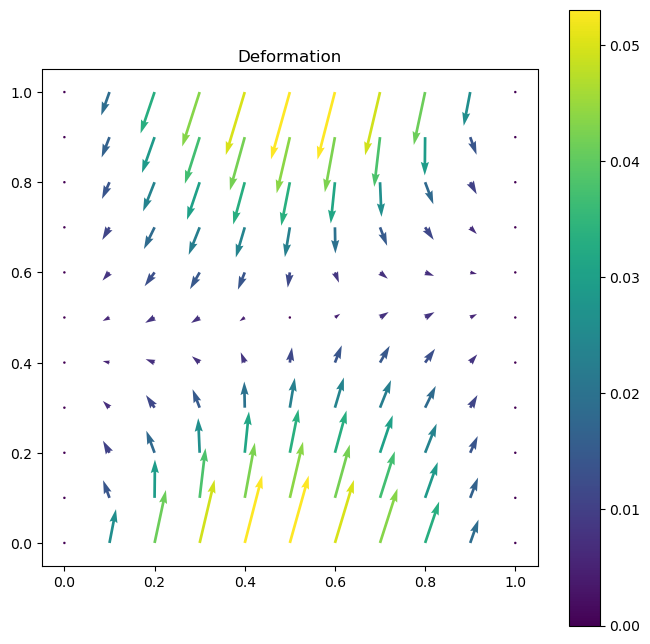

In [110]:
fig = plt.figure(figsize=(8, 8))
plt.colorbar(plot(u))
plt.title('Deformation');

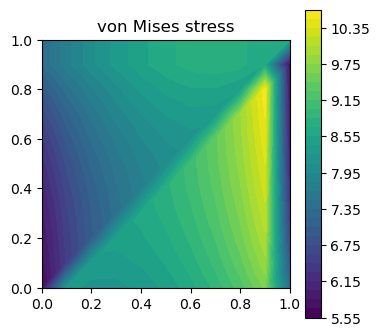

In [111]:
fig = plt.figure(figsize=(4,4))
plt.colorbar(plot(von_Mises)) # Note that plotting with matplotlib interpolates the solution into P1, this reduces the accuracy of the stresses
plt.title('von Mises stress');

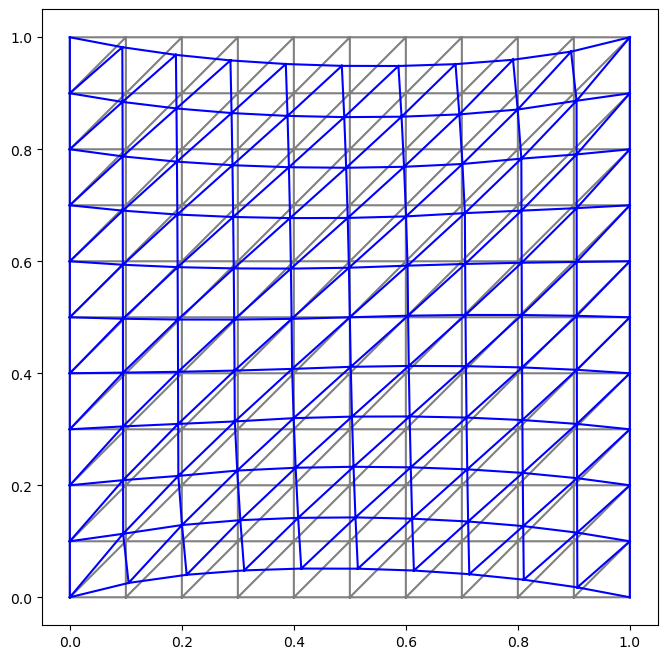

In [112]:
# Plot reference domain and deformed domain

# To compute the deformed domain, we use the ALE framework as implemented in fenics
fig = plt.figure(figsize=(8,8))
plot(mesh)
deformed_mesh = mesh
ALE.move(deformed_mesh, u)
plot(deformed_mesh, color="b")
# NB: mesh is now deformed, so let us remake it so we get back to the reference domain
mesh = UnitSquareMesh(5,5)

### Final exercises

1. Change the code so that the top and bottom are clamped and the sides are allowed to deform.
2. Change the code so that you implement a shear strain, i.e. $u=(1,0)$ on the top and $u=(0,0)$ on the bottom. You can set $p_D=0$ on the lateral boundaries for simplicity.
2. Play with the parameters $\lambda$ and $\mu$. What happens when you increase/decrease each of these? 